In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from modules.numeric import *

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

In [4]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='computer modern roman')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,bm,physics,lmodern}')

In [5]:
phi4 = Phi4()

def chi(H, mu, nu):
    return np.arctanh((mu*H)**nu)

def varphi(x, mu, nu):
    return -mu*np.tanh(x)**nu

def phi_dirichlet(x, H):
    assert H > -1
    mu = 1
    nu = 1 if H < 1 else -1
    return np.r_[[1]*len(x)] if H == 1 else varphi(x - chi(H, mu, nu), mu, nu)

def y0(x, x0, v, H):
    return np.stack((
        phi_dirichlet(x, H) + phi4.kink(x - x0, 0, v) - 1,
        phi4.kink_dt(x - x0, 0, v)
    ))

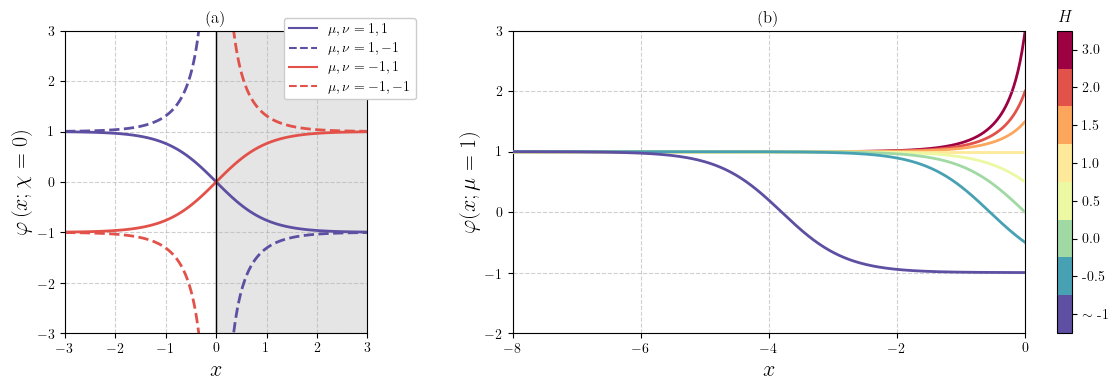

In [6]:
values = np.r_[-0.999, -0.5, 0, 0.5, 1, 1.5, 2, 3]
cmap = plt.get_cmap('Spectral_r', len(values))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.8]})

cs = {1:cmap(0), -1:cmap(len(values)-2)}
ls = {1:'-', -1:'--'}

x = np.linspace(-3, 3, 250)
for mu in (1, -1):
    for nu in (1, -1):
        ax1.plot([], [], c=cs[mu], ls=ls[nu], label=r'$\mu, \nu = {%s}, {%s}$'%(mu, nu))
        for i, xi in enumerate((x[x < 0], x[x > 0])):
            ax1.plot(xi, varphi(xi, mu, nu), c=cs[mu], ls=ls[nu], lw=2)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(-3, 3)

ax1.set_xlabel(r'$x$', fontsize=16)
ax1.set_ylabel(r'$\varphi\left(x;\chi=0\right)$', fontsize=16)
        
ax1.grid(alpha=0.6, ls='--')
ax1.legend(framealpha=1, bbox_to_anchor=(0.7, 0.75))
ax1.set_title('(a)')

ax1.axvline(0, ls='-', lw=1, c='k')
ax1.set_aspect('equal')

ax1.fill_betweenx((-3, 3), 0, 5, alpha=0.1, color='k')

x = np.linspace(-8, 0, 500)

for i, H in enumerate(values):
    ax2.plot(x, phi_dirichlet(x, H), c=cmap(i), lw=2, zorder=len(values)-i)

ax2.set_ylim(-2, 3)
ax2.set_xlim(x.min(), x.max())

ax2.set_yticks((-2, -1, 0, 1, 2, 3))

ax2.set_xlabel(r'$x$', fontsize=16)
ax2.set_ylabel(r'$\varphi(x; \mu=1)$', fontsize=16)
ax2.set_xticks((0, -2, -4, -6, -8))
ax2.grid(alpha=0.6, ls='--', zorder=-1)
ax2.set_title('(b)')

dvs = np.r_[-1.5, values]
cbar = fig.colorbar(ScalarMappable(norm=BoundaryNorm(dvs, ncolors=len(dvs)), cmap=ListedColormap([cmap(i) for i in range(len(dvs))])), ax=ax2)
cbar.ax.set_yticks((dvs[:-1] + dvs[1:])/2, (r'$\sim$ -1', *values[1:]))
cbar.minorticks_off()
cbar.ax.set_title(r'$H$')

fig.tight_layout()
fig.savefig('reports/dirichlet/solutions.pdf', bbox_inches='tight', dpi=2000, pad_inches=0)
plt.show()

In [7]:
L = 100
N = 1024
DX = L/(N - 1)
DT = 4e-2
X0 = -10

In [33]:
booster = Booster(
    x_lattice= (-L, 0, N), 
    dt= DT, 
    order= 4,
    y0= y0,
    pot_diff= phi4.diff,
    boundaries= ('reflective', 'dirichlet'),
    integrator='sy6'
)

def plot_boundary_scatter(v, H, t_final=100, ax=None):
    if ax == None: ax = plt.gca()
    booster.rb.param = H
    lat, Y = booster.run(t_final, v=v, x0=X0, H=H)
    y, dydt = Y[:, 0], Y[:, 1]
    ax.imshow(y, cmap='Spectral_r', vmin=-1, vmax=1, extent=(lat.x.min(), lat.x.max(), lat.t.min(), lat.t.max()), aspect='auto', origin='lower')
    ax.set_xlim(-30, 0)
    return lat, y, dydt

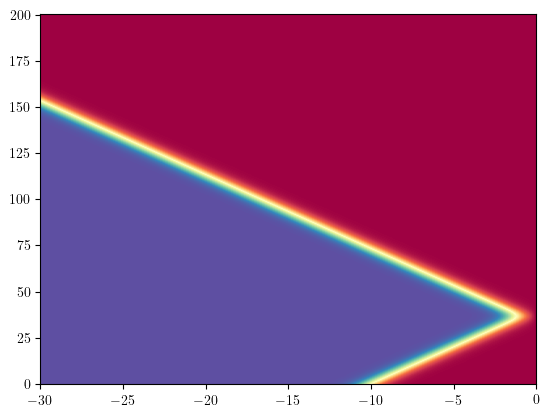

In [38]:
lat, y, dydt = plot_boundary_scatter(0.25, 1, t_final=200)
plt.show()

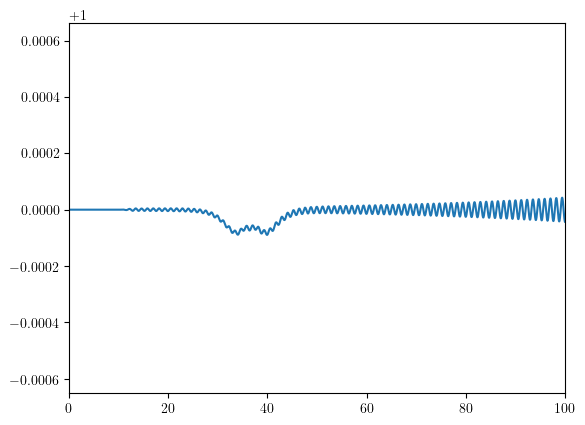

In [39]:
plt.plot(lat.t, y[:, -1])
# plt.plot(lat.t, dydt[:, -1])
plt.xlim(0, 100)
plt.show()

In [25]:
from scipy.signal import find_peaks

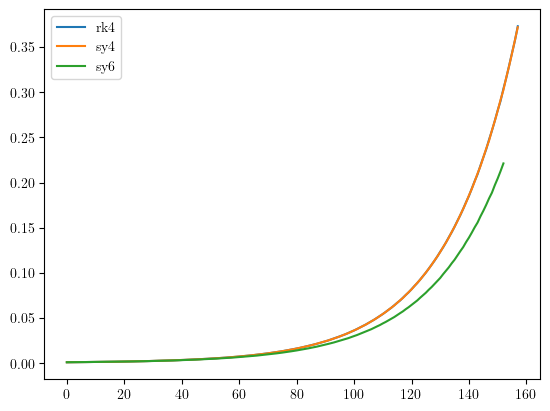

In [60]:
v, H, t_final = 0, 0, 200

for integrator in ('rk4', 'sy4', 'sy6'):
    booster = Booster(
        x_lattice= (-L, 0, N), 
        dt= DT, 
        order= 4,
        y0= y0,
        pot_diff= phi4.diff,
        boundaries= ('reflective', 'dirichlet'),
        integrator=integrator
    )
    booster.rb.param = H
    lat, Y = booster.run(t_final, v=v, x0=X0, H=H)
    y, dydt = Y[:, 0], Y[:, 1]
    peaks, _ = find_peaks(y[:, -1])
    plt.plot(np.abs(y[peaks, -1] - H), label=integrator)
plt.legend()
plt.show()

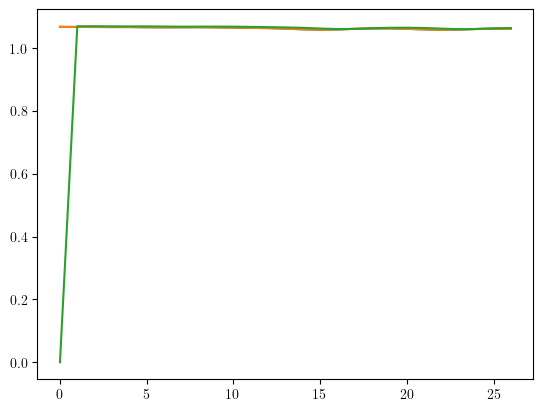

In [57]:
v, H, t_final = 0, 0, 200

for integrator in ('rk4', 'sy4', 'sy6'):
    booster = Booster(
        x_lattice= (-L, 0, N), 
        dt= DT, 
        order= 6,
        y0= y0,
        pot_diff= phi4.diff,
        boundaries= ('reflective', 'dirichlet'),
        integrator=integrator
    )
    booster.rb.param = H
    lat, Y = booster.run(t_final, v=v, x0=X0, H=H)
    y, dydt = Y[:, 0], Y[:, 1]
    peaks, _ = find_peaks(np.abs(y[:, -1]))
    plt.plot(np.abs(y[peaks, -1] - H))
# plt.semilogy()

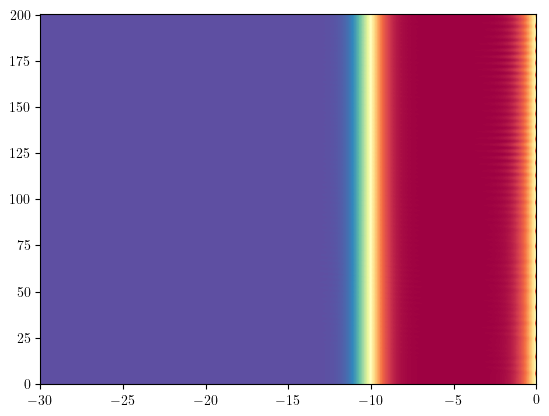

In [59]:
plot_boundary_scatter(0, 0, t_final=200)
plt.show()

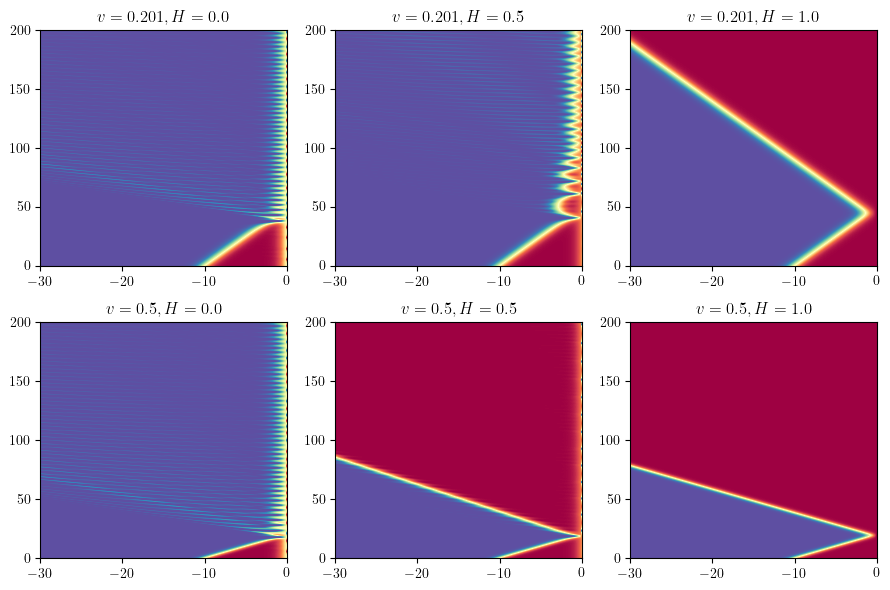

In [10]:
V = (0.201, 0.5)
Hs = (0, 0.5, 1)

c = len(Hs)
r = len(V)
fig, axs = plt.subplots(r, c, figsize=(c*3, 3*r))

for ax, (v, H) in zip(np.ravel(axs), np.r_[np.meshgrid(V, Hs)].T.reshape((-1, 2))):
    plot_boundary_scatter(v, H, t_final=200, ax=ax)
    ax.set_title(r'$v=%s, H=%s$'%(v, H))

fig.tight_layout()

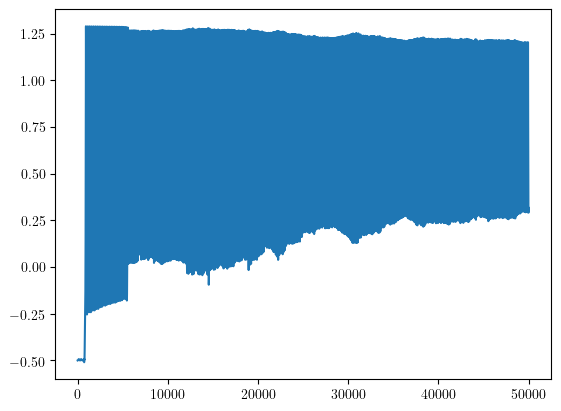

In [ ]:
plt.plot(y[:, -1])

In [30]:
N = 302
V = np.linspace(0, 1, N)[1:-1]
T = 100

In [32]:
H = 0
Y = []
for i, v in enumerate(V):
    print(f'{(i/N * 100):.2f}%', end='\r')
    booster.rb.set_param(H)
    Yi = []
    booster.run(T, {'x0':X0, 'v':v, 'H':H}, callback=composite(memory_economize, catch_cm(cm_index=-2, Ycm= Yi)))
    Y.append(Yi)

/home/jairo/Documentos/GitHub/parallel-kink-scattering/modules/numeric/models.py:13: RuntimeWarning: overflow encountered in square
  return -gamma*v/np.cosh(gamma*(x - v*t))**2


/home/jairo/Documentos/GitHub/parallel-kink-scattering/modules/numeric/models.py:13: RuntimeWarning: overflow encountered in cosh
  return -gamma*v/np.cosh(gamma*(x - v*t))**2


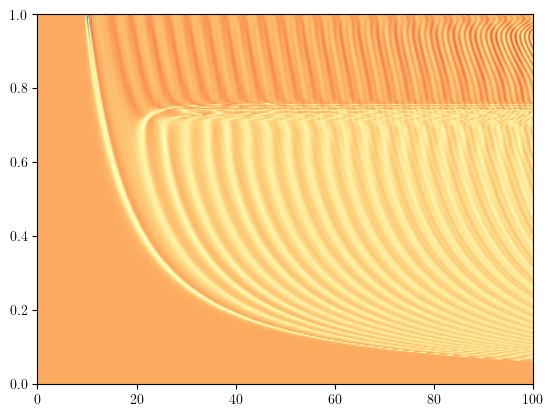

In [40]:
plt.imshow(Y, aspect='auto', extent=(0, T, 0, 1), origin='lower', cmap='Spectral_r')

In [74]:
N = 302
V = np.linspace(0.72, 0.78, N)[1:-1]
T = 100

In [75]:
alpha = 0
Y = []
for i, v in enumerate(V):
    print(f'{(i/N * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    Yi = []
    booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha}, callback=composite(memory_economize, catch_cm(cm_index=-2, Ycm= Yi)))
    Y.append(Yi)

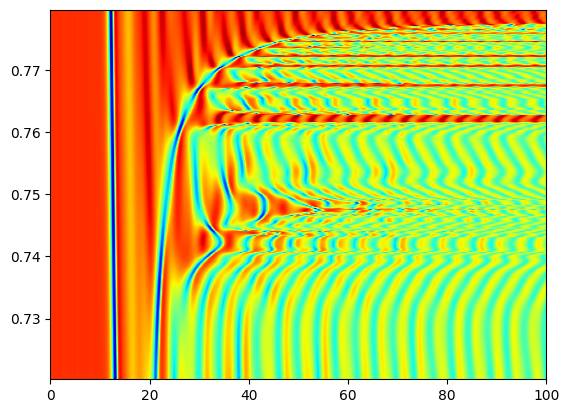

In [79]:
plt.imshow(Y, aspect='auto', extent=(0, T, V.min(), V.max()), origin='lower', cmap='jet')

In [15]:
alpha = 0.2
Y = []
for i, v in enumerate(V):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

/home/jairo/Documentos/GitHub/parallel-kink-scattering/modules/numeric/models.py:13: RuntimeWarning: overflow encountered in square
  return -gamma*v/np.cosh(gamma*(x - v*t))**2


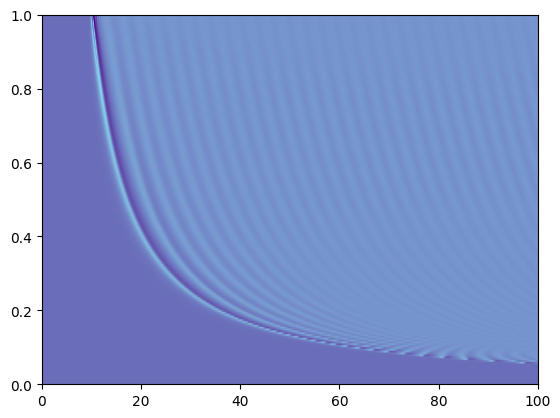

In [17]:
plt.imshow(Y, aspect='auto', extent=(0, T, 0, 1), origin='lower', cmap=CMAP, vmin=-2, vmax=2)

In [18]:
alpha = 0.5
Y = []
for i, v in enumerate(V):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

/home/jairo/Documentos/GitHub/parallel-kink-scattering/modules/numeric/models.py:13: RuntimeWarning: overflow encountered in square
  return -gamma*v/np.cosh(gamma*(x - v*t))**2


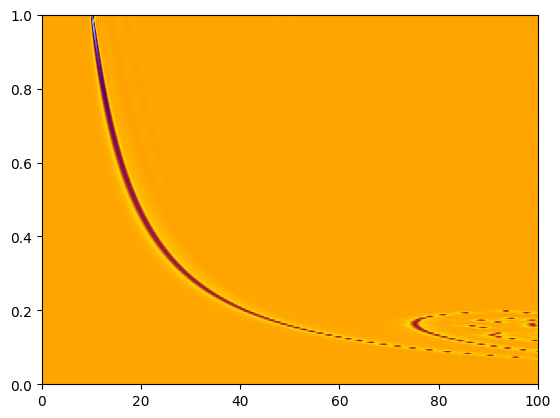

In [22]:
plt.imshow(Y, aspect='auto', extent=(0, T, 0, 1), origin='lower', cmap=CMAP)

In [11]:
alpha = -0.1
Y = []
for i, v in enumerate(V):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

/home/jairo/Documentos/GitHub/parallel-kink-scattering/modules/numeric/models.py:13: RuntimeWarning: overflow encountered in square
  return -gamma*v/np.cosh(gamma*(x - v*t))**2


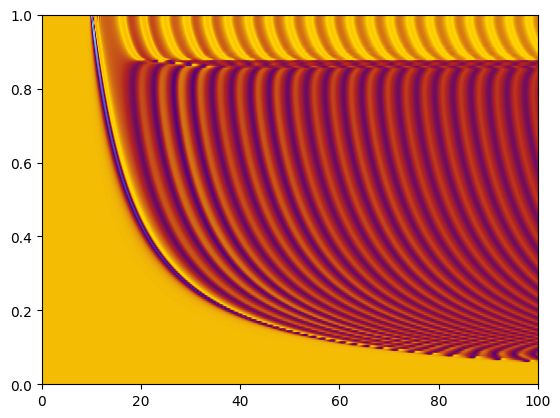

In [12]:
plt.imshow(Y, aspect='auto', extent=(0, T, 0, 1), origin='lower', cmap=CMAP)

In [16]:
alpha = -0.9
Y = []
for i, v in enumerate(V):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

/home/jairo/Documentos/GitHub/parallel-kink-scattering/modules/numeric/models.py:13: RuntimeWarning: overflow encountered in square
  return -gamma*v/np.cosh(gamma*(x - v*t))**2


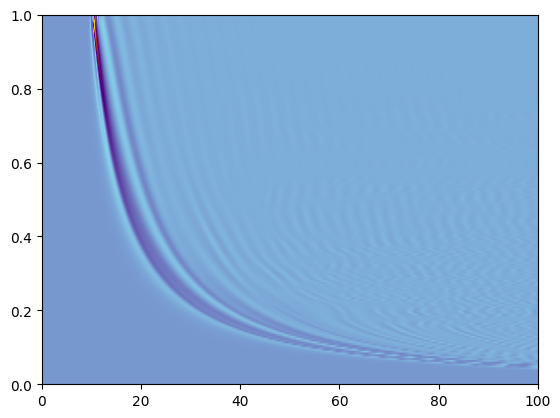

In [18]:
plt.imshow(Y, aspect='auto', extent=(0, T, 0, 1), origin='lower', cmap=CMAP)

In [11]:
A = np.linspace(1, -1, 201)[:-1]
v = 0.2
Y = []
for i, alpha in enumerate(A):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

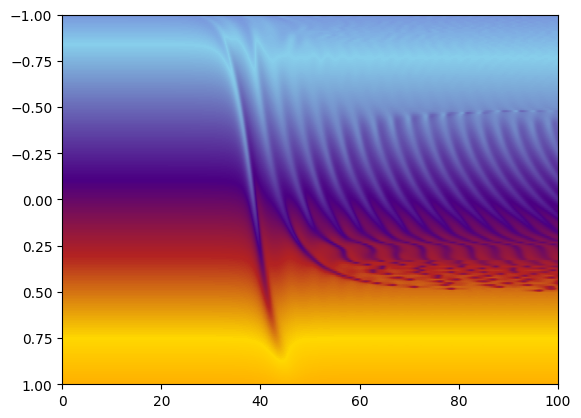

In [18]:
plt.imshow(Y, aspect='auto', extent=(0, T, 1, -1), origin='lower', cmap=CMAP, vmin=-2, vmax=2)

In [19]:
A = np.linspace(1, -1, 201)[:-1]
v = 0.5
Y = []
for i, alpha in enumerate(A):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

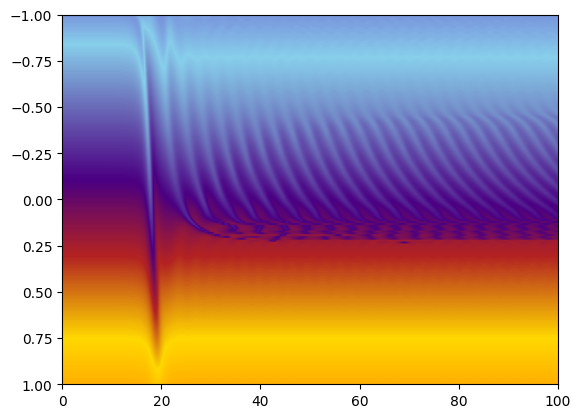

In [20]:
plt.imshow(Y, aspect='auto', extent=(0, T, 1, -1), origin='lower', cmap=CMAP, vmin=-2, vmax=2)

In [21]:
A = np.linspace(1, -1, 201)[:-1]
v = 0.9
Y = []
for i, alpha in enumerate(A):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

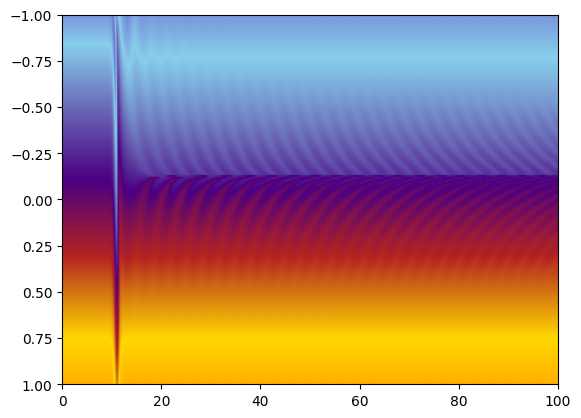

In [22]:
plt.imshow(Y, aspect='auto', extent=(0, T, 1, -1), origin='lower', cmap=CMAP, vmin=-2, vmax=2)

In [21]:
A = np.linspace(0.5, 0, 201)[:-1]
v = 0.2
Y = []
for i, alpha in enumerate(A):
    print(f'{(i/200 * 100):.2f}%', end='\r')
    booster.rb.set_param(alpha)
    _, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    Y.append(y[:, -2])

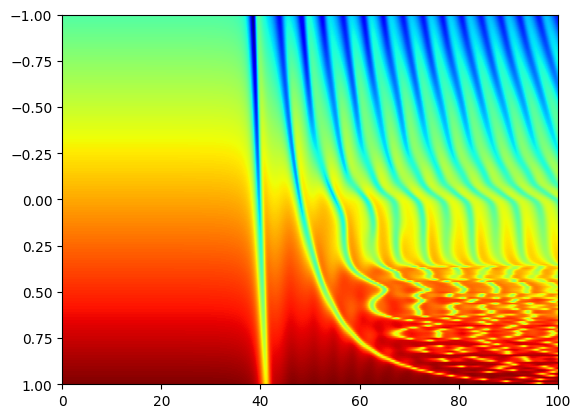

In [22]:
plt.imshow(Y, aspect='auto', extent=(0, T, 1, -1), origin='lower', cmap='jet')

In [16]:
import sympy as sp
import numpy as np
from math import factorial

In [17]:
m = 1
order = 5
mu = 2

In [28]:
K = np.arange(order)
M = sp.Matrix(np.r_[
    [np.where(K == m, factorial(m), 0)],
    np.vander(K[1:order], order, increasing=True)
])
M

Matrix([
[0, 1,  0,  0,   0],
[1, 1,  1,  1,   1],
[1, 2,  4,  8,  16],
[1, 3,  9, 27,  81],
[1, 4, 16, 64, 256]])

In [29]:
C = M.inv()
C

Matrix([
[-12/25,   48/25, -36/25, 16/25,  -3/25],
[     1,       0,      0,     0,      0],
[ -7/10,  -23/15,  53/20,  -7/5,  17/60],
[   1/5,    7/10,   -7/5,  9/10,   -1/5],
[ -1/50, -13/150, 19/100, -7/50, 11/300]])

In [32]:
C_tilde = [[sum([i**(j-mu)*factorial(j)*C[j,k]/factorial(j - mu) for j in range(mu, order)]) for k in range(order)] for i in (0, 1)]
C_tilde

[[-7/5, -46/15, 53/10, -14/5, 17/30], [-11/25, 7/75, -41/50, 23/25, -29/150]]

In [35]:
4//2

2